<a href="https://colab.research.google.com/github/raoyongming/DynamicViT/blob/master/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/raoyongming/DynamicViT.git

Cloning into 'DynamicViT'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 110 (delta 49), reused 90 (delta 32), pack-reused 0
Receiving objects: 100% (110/110), 4.42 MiB | 21.23 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
!pip install timm

     |████████████████████████████████| 376 kB 5.6 MB/s 


In [ ]:
import os
os.chdir("/content/DynamicViT")
os.mkdir("./pretrained")

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I" -O dynamic-vit_lv-m_r0.7.pth && rm -rf /tmp/cookies.txt
!mv ./dynamic-vit_lv-m_r0.7.pth ./pretrained/

--2021-12-23 06:38:55--  https://docs.google.com/uc?export=download&confirm=Akii&id=1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I
Resolving docs.google.com (docs.google.com)... 142.250.152.139, 142.250.152.100, 142.250.152.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-ac-docs.googleusercontent.com/docs/securesc/14ceqtos2gc1rk1554be24e4gqsqq1kk/e85k76q9kepttltj9c71nhj9rsulik1p/1640241525000/16817155093637665231/12433505655059521480Z/1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I?e=download [following]
--2021-12-23 06:38:55--  https://doc-0s-ac-docs.googleusercontent.com/docs/securesc/14ceqtos2gc1rk1554be24e4gqsqq1kk/e85k76q9kepttltj9c71nhj9rsulik1p/1640241525000/16817155093637665231/12433505655059521480Z/1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I?e=download
Resolving doc-0s-ac-docs.googleusercontent.com (doc-0s-ac-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Conne

In [ ]:
import torch
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from lvvit import LVViTDiffPruning

In [ ]:
# build transforms
from torchvision import datasets, transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

t_resize_crop = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
])

t_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
# build model
BASE_RATE = 0.7
KEEP_RATE = [BASE_RATE, BASE_RATE ** 2, BASE_RATE ** 3]
PRUNING_LOC = [5, 10, 15]
CKPT_PATH = 'pretrained/dynamic-vit_lv-m_r0.7.pth'

model = LVViTDiffPruning(
    patch_size=16, embed_dim=512, depth=20, num_heads=8, mlp_ratio=3.,
    p_emb='4_2',skip_lam=2., return_dense=True, mix_token=True,
    pruning_loc=PRUNING_LOC, token_ratio=KEEP_RATE, viz_mode=True,
)

checkpoint = torch.load(CKPT_PATH, map_location='cpu')['model']
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
def get_keep_indices(decisions):
    keep_indices = []
    for i in range(3):
        if i == 0:
            keep_indices.append(decisions[i])
        else:
            keep_indices.append(keep_indices[-1][decisions[i]])
    return keep_indices
def gen_masked_tokens(tokens, indices, alpha=0.2):
    indices = [i for i in range(196) if i not in indices]
    tokens = tokens.copy()
    tokens[indices] = alpha * tokens[indices] + (1 - alpha) * 255
    return tokens

def recover_image(tokens):
    # image: (C, 196, 16, 16)
    image = tokens.reshape(14, 14, 16, 16, 3).swapaxes(1, 2).reshape(224, 224, 3)
    return image

def gen_visualization(image, decisions):
    keep_indices = get_keep_indices(decisions)
    image = np.asarray(image)
    image_tokens = image.reshape(14, 16, 14, 16, 3).swapaxes(1, 2).reshape(196, 16, 16, 3)

    stages = [
        recover_image(gen_masked_tokens(image_tokens, keep_indices[i]))
        for i in range(3)
    ]
    viz = np.concatenate([image] + stages, axis=1)
    return viz

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


(-0.5, 895.5, 223.5, -0.5)

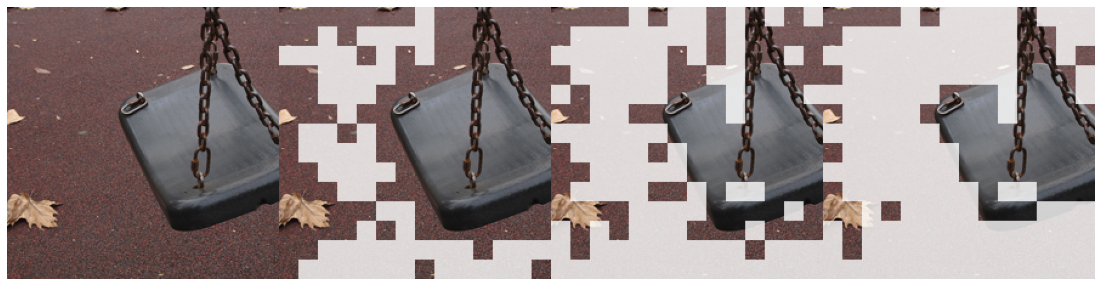

In [ ]:
# visualization
# use a random image from IMAGE_ROOT

IMAGE_ROOT = 'imgs'
image_paths = glob.glob(f'imgs/*.jpg')
idx = np.random.randint(len(image_paths))
image_path = image_paths[idx]
image = Image.open(image_path)

image = t_resize_crop(image)
im_tensor = t_to_tensor(image).unsqueeze(0)

device = 'cpu'
model.to(device)
model.eval()
im_tensor = im_tensor.to(device)
with torch.cuda.amp.autocast():
    output, decisions = model(im_tensor)
decisions = [decisions[i][0][0].cpu().numpy() for i in range(3)]
viz = gen_visualization(image, decisions)

plt.figure(figsize=(20, 5))
plt.imshow(viz)
plt.axis('off')